In [2]:
import spikeinterface.full as si
import probeinterface as pif
from probeinterface.plotting import plot_probe
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os

In [32]:
%matplotlib widget

Text(0.5, 1.0, 'NPX 1')

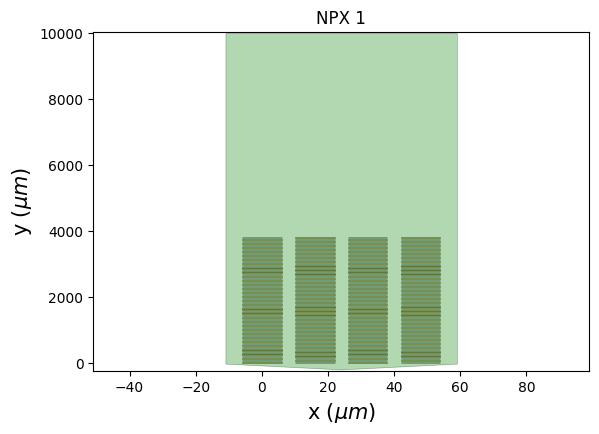

In [3]:
# path to meta file
meta_filename = 'D://NPX_Data//M388-2023-11-20_2_g0//M388-2023-11-20_2_g0_imec0//M388-2023-11-20_2_g0_tcat.imec0.ap.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
plot_probe(probe, ax=ax)
ax.set_aspect(0.01) # Lower values make the x axis scale larger
ax.set_title('NPX 1')
# ax.set_ylim([3400, 4000]) #Set this according to what you want to see

In [4]:
raw_rec = si.read_spikeglx('D://NPX_Data//M388-2023-11-20_2_g0//M388-2023-11-20_2_g0_imec0', \
                           stream_name='imec0.ap')
# non_neuronal = si.read_spikeglx(npx_path, stream_name='nidq', all_annotations=True)
# Turns out only the the analog streams are read from thhe .nidq file, and not the digital events.

In [5]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
print('bad_channel_ids, channel_labels')
for bad_channel_id in bad_channel_ids:
    index = int(bad_channel_id.split('AP')[1])
    print('{}, {}'.format(bad_channel_id, channel_labels[index]))

bad_channel_ids, channel_labels
imec0.ap#AP191, dead
imec0.ap#AP364, out
imec0.ap#AP365, out
imec0.ap#AP366, out
imec0.ap#AP367, out
imec0.ap#AP368, out
imec0.ap#AP369, out
imec0.ap#AP370, out
imec0.ap#AP371, out
imec0.ap#AP372, out
imec0.ap#AP373, out
imec0.ap#AP374, out
imec0.ap#AP375, out
imec0.ap#AP376, out
imec0.ap#AP377, out
imec0.ap#AP378, out
imec0.ap#AP379, out
imec0.ap#AP380, out
imec0.ap#AP381, out
imec0.ap#AP382, out
imec0.ap#AP383, out


In [6]:
#Remove bad channels after crosschecking with SpikeGLX viewer
rec1 = rec1.remove_channels(bad_channel_ids)
np.shape(rec1.get_channel_locations())

(363, 2)

# **Kilosort requires a binary file as input so the code below does that**

In [ ]:
ks_working_folder = 'E://Temp'
# Make sure it exits and is in on the fastest memory drive
os.path.exists(ks_working_folder)

In [ ]:
# Run this only if binary recording hasn't been written yet
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
rec = rec1.save(folder=os.path.join(ks_working_folder,'preprocess'), format='binary', **job_kwargs)

## **Run this only if the binary recording has already been written and progress was lost after that step**

In [ ]:
# Number of good channels
gc = 363;
rec = si.BinaryRecordingExtractor('/ks2_t/preprocess/traces_cached_seg0.raw', 30000, 'int16', gc) 
# Hacky Steps because Binary recordings does not contain the following properties
rec.set_channel_locations(rec1.get_channel_locations())
rec.set_probe(rec1.get_probe())
rec.set_property('contact_vector', rec1.get_property('contact_vector'))
rec.annotate(is_filtered=True)

In [ ]:
# check manually for drifts (Straight lines are good, slanting lines indeicate drift)
rec2 = si.common_reference(rec1, operator="median", reference="global")
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec2,  method='locally_exclusive',
                     detect_threshold=5, **job_kwargs)
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec2, peaks, method='center_of_mass', **job_kwargs)

fs = rec2.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.', alpha=0.002)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
ax.set_ylim(1000, 1500)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [ ]:
ks2_path = 'C://Users//mvdmlab/Documents//GitHub//Kilosort-2.5'
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed() # Should return true, if not change path accordingly

In [ ]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')
print(ks2_5_params)

In [ ]:
sorting = si.run_sorter('kilosort2_5', rec, output_folder=os.path.join(ks_working_folder, 'ks2_output'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

In [7]:
# After refining via phy, use this to retain only the goos cells
sorting2 = si.KiloSortSortingExtractor('E://Temp//ks2_output//sorter_output')
sorting2.get_property_keys()

['original_cluster_id',
 'Amplitude',
 'ContamPct',
 'KSLabel',
 'amp',
 'ch',
 'depth',
 'fr',
 'quality',
 'n_spikes',
 'sh']

In [9]:
# quality is written by user, KSLabel is from Kilosort, use the former to select stuff
unit_ids = (np.where(sorting2.get_property('quality') == 'good'))

In [ ]:
# How to export this to NWB or whatever?/ Maybe Pynapple

In [ ]:
# This is a super long time taking step, not sure in what case it is needed
# si.export_to_phy(we, os.path.join(ks_working_folder, 'si_phy'), **job_kwargs)

# LFP analysis (TBD)

In [10]:
# Downsample the channels
new_fs = 2500 # Hz
dwnsmp_rec = si.resample(raw_rec,new_fs)
dwnsmp_rec.get_sampling_frequency() # Should be equal to new_fs

2500

In [11]:
# Bandpass Filter the LFP in the typical LFP range
filt_rec = si.bandpass_filter(dwnsmp_rec, freq_min=0.1, freq_max=500.)
filt_rec.get_annotation('is_filtered')

True

In [12]:
# If channels were noisy, we shuld remove them from potential LFPs too
filt_rec = filt_rec.remove_channels(bad_channel_ids)

In [14]:
# a way to ensure only unique depth channels are considered:
# Initialize a variable to keep track of the previous number

# Decide the depth spacing to decide how many LFPs to keep
depth_spacing = 200 # microns
all_depths = [x[1] for x in filt_rec.get_channel_locations()]

prev_num = None

# Initialize a list to store the indices
ch_idx = []

# Iterate over the sorted array along with their indices
for i, num in enumerate(all_depths):
    # Check if the current number is different from the previous number
    if (num != prev_num) and (num % depth_spacing == 0):
        ch_idx.append(i)
    # Update the previous number
    prev_num = num

# Print the selected indices
print(filt_rec.get_channel_locations()[ch_idx])

[[  16.    0.]
 [  16.  200.]
 [  16.  400.]
 [  16.  600.]
 [  16.  800.]
 [  16. 1000.]
 [  16. 1200.]
 [  16. 1400.]
 [  16. 1600.]
 [  16. 1800.]
 [  16. 2000.]
 [  16. 2200.]
 [  16. 2400.]
 [  16. 2600.]
 [  16. 2800.]
 [  16. 3000.]
 [  16. 3200.]
 [  16. 3400.]
 [  16. 3600.]]


In [24]:
ch_ids = filt_rec.get_channel_ids()[ch_idx]
ch_depths = filt_rec.get_channel_locations()[ch_idx,1]
np.shape(ch_ids)

(19,)

In [39]:
sel_lfp = filt_rec.clone()
remove_ids = [x for x in filt_rec.get_channel_ids() if x not in ch_ids]
sel_lfp = sel_lfp.remove_channels(remove_ids)
np.shape(sel_lfp.get_channel_ids()) # should be the number of LFPs selected

(19,)

In [60]:
si.plot_traces(sel_lfp, backend= 'ipywidgets', time_range=[1000,1010], order_channel_by_depth=True)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [55]:
# Keep Units judged to be good by Kyoko
rm_idx = [i for i,x in enumerate(sorting2.get_property('quality')) if x !='good']
print(np.shape(rm_idx), np.shape(sorting2.get_property('quality')))

(157,) (244,)


In [59]:
clean_units = sorting2.clone()
clean_units = clean_units.remove_units(clean_units.get_unit_ids()[rm_idx])
clean_units.get_property('quality') # Should be all 'good'

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good'],
      dtype=object)

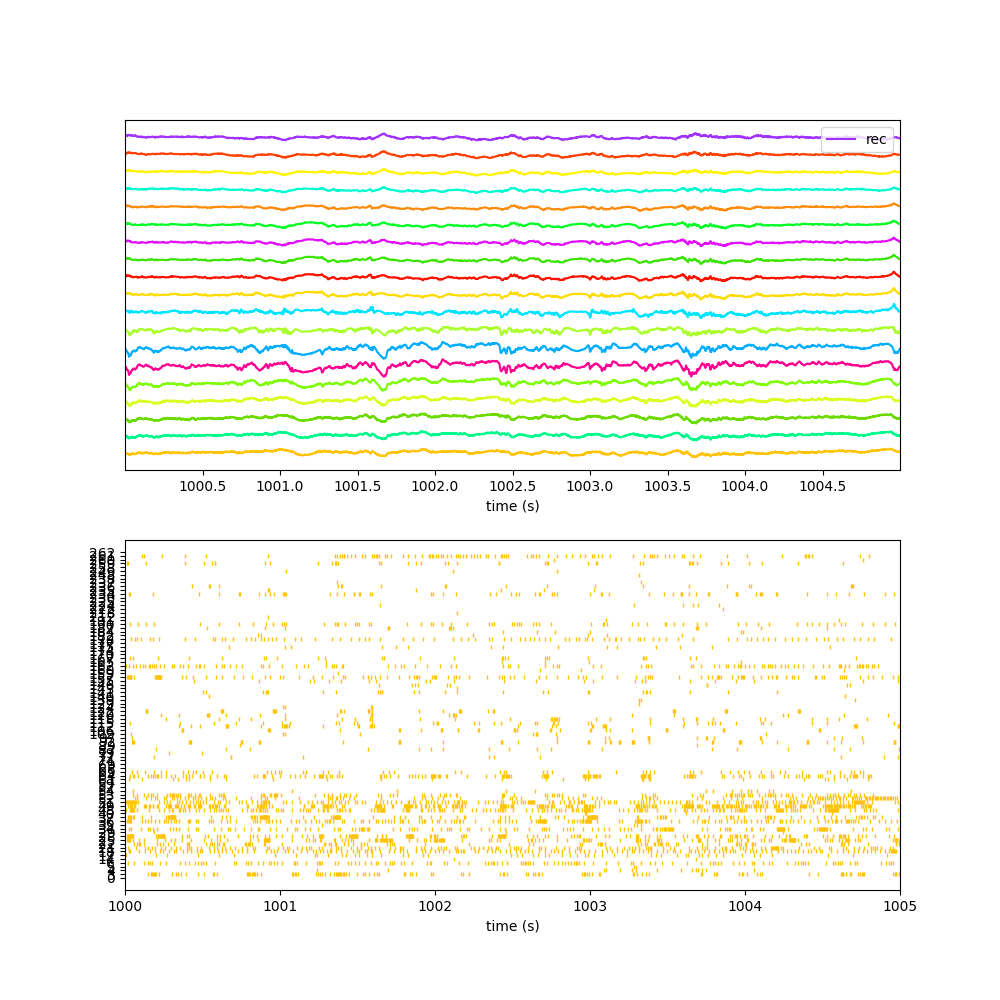

In [117]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))
sel_lfp.set_channel_groups(np.arange(len(sel_lfp.get_channel_ids()))) # To show different colors
si.plot_traces(sel_lfp, backend= 'matplotlib', ax = axs[0], time_range=[1000,1005], order_channel_by_depth=True, color_groups=True)
# Some hacky way to get the colors used, the first color is the one plotted at the bottom and it goes upwards
c_used = []
for line in fig.get_axes()[0].get_lines():
    c_used.append(line.get_color())
si.plot_rasters(clean_units, backend= 'matplotlib', ax = axs[1], time_range=[1000,1005], color=c_used[0])

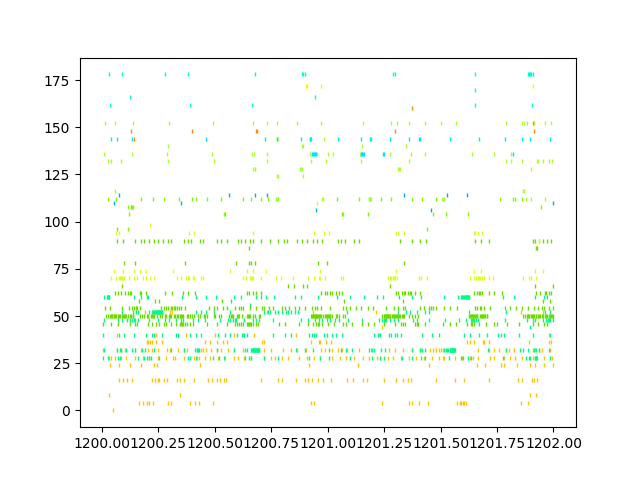

In [135]:
fig, axs = plt.subplots()
last_idx = 0
for gd in range(0,(int)(np.max(ch_depths))+1,200):
    t_units = clean_units.clone()
    rm_idx = [i for i,x in enumerate(t_units.get_property('depth')) if (x < gd) or (x >= gd+200)]
    # print(rm_idx)
    t_units = t_units.remove_units(t_units.get_unit_ids()[rm_idx])
    for unit_index, unit_id in enumerate(t_units.get_unit_ids()):
        spiketrain = t_units.get_unit_spike_train( unit_id, start_frame=1200*t_units.sampling_frequency, \
                                                  end_frame=1202*t_units.sampling_frequency,segment_index=0)
        spiketimes = spiketrain / float(t_units.sampling_frequency)
        axs.plot(spiketimes, 2*(last_idx+unit_index) * np.ones_like(spiketimes), marker="|", mew=1, \
                    markersize=3, ls="", color=c_used[(int)(gd/200)])
        last_idx = last_idx+1
    